This notebook attempts to extract images of single seeds from the raw video data.

Requirements:

```sh
pip install matplotlib opencv-python numpy
```

In [1]:
import cv2

In [2]:
vidcap = cv2.VideoCapture('raw/kaura_1.avi', None)

nth_frame = 30
frames = []
frame_counter = 0

while True:
    success, image = vidcap.read()
    if not success: break

    frame_counter += 1
    if frame_counter == nth_frame:
        frame_counter = 0
        frames.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

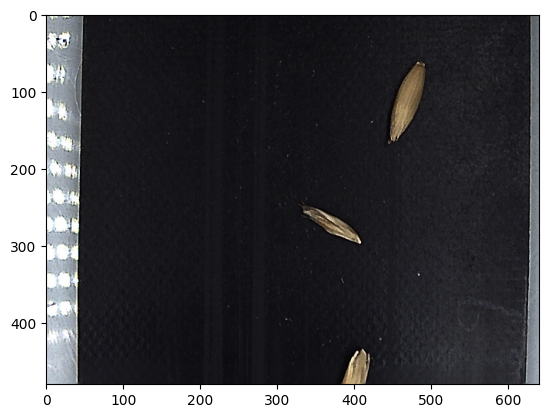

In [3]:
import matplotlib.pyplot as plt
import random

plt.imshow(frames[80])

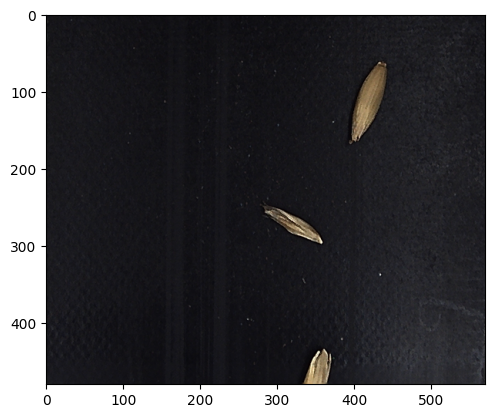

In [4]:
# Crop the image to get rid of the left and right edges

cropped_frames = [frame[:, 50:620] for frame in frames]

plt.imshow(cropped_frames[80])

75.0


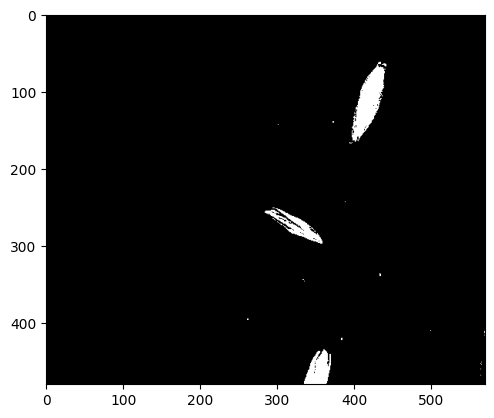

In [5]:
# Threshold the image

SEED_THRESHOLD = 75

grayscale_frames = [cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) for frame in cropped_frames]
thresholded_frames = [cv2.threshold(frame, SEED_THRESHOLD, 255, cv2.THRESH_BINARY) for frame in grayscale_frames]

print(thresholded_frames[80][0])

plt.imshow(thresholded_frames[80][1], 'gray',vmin=0,vmax=255)

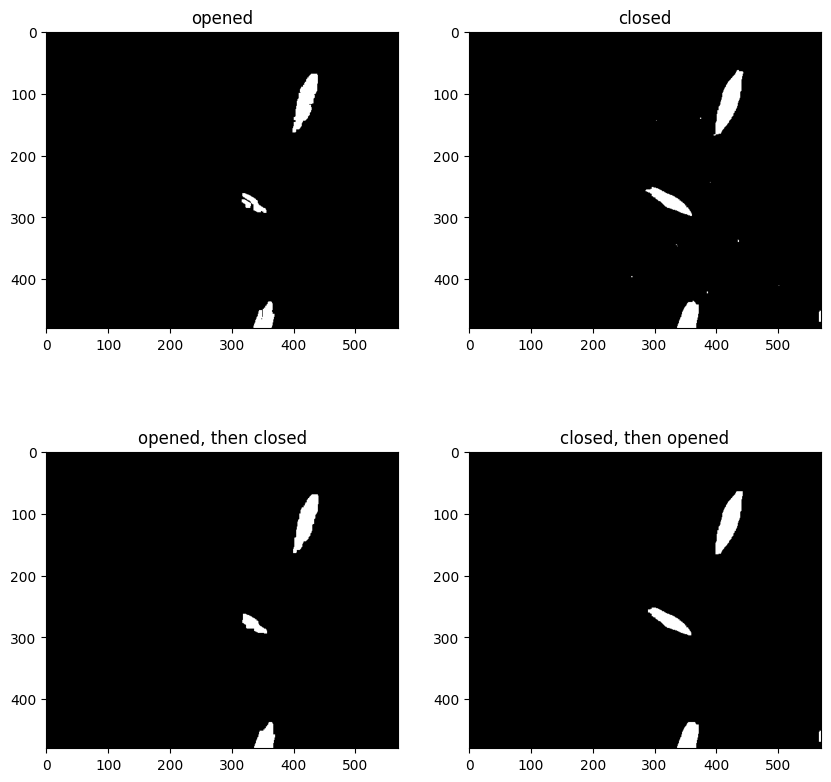

In [6]:
import numpy as np

# Try different morphological operations on the image

close_kernel = np.ones((10, 10), np.uint8)
open_kernel = np.ones((5, 5), np.uint8)

test_opened = cv2.morphologyEx(thresholded_frames[80][1], cv2.MORPH_OPEN, open_kernel)
test_closed = cv2.morphologyEx(thresholded_frames[80][1], cv2.MORPH_CLOSE, close_kernel)
test_opened_closed = cv2.morphologyEx(test_opened, cv2.MORPH_CLOSE, close_kernel)
test_closed_opened = cv2.morphologyEx(test_closed, cv2.MORPH_OPEN, open_kernel)

test_images = [test_opened, test_closed, test_opened_closed, test_closed_opened]
test_titles = ['opened', 'closed', 'opened, then closed', 'closed, then opened']

plt.figure(figsize=(10,10))
for i, (image, title) in enumerate(zip(test_images, test_titles)):
    plt.subplot(2,2,i+1)
    plt.imshow(image, 'gray',vmin=0,vmax=255)
    plt.title(title)

Closing and then opening the image seems to be quite useful. Let's try masking the image using it with some dilation.

Text(0.5, 1.0, 'masked using dilated mask')

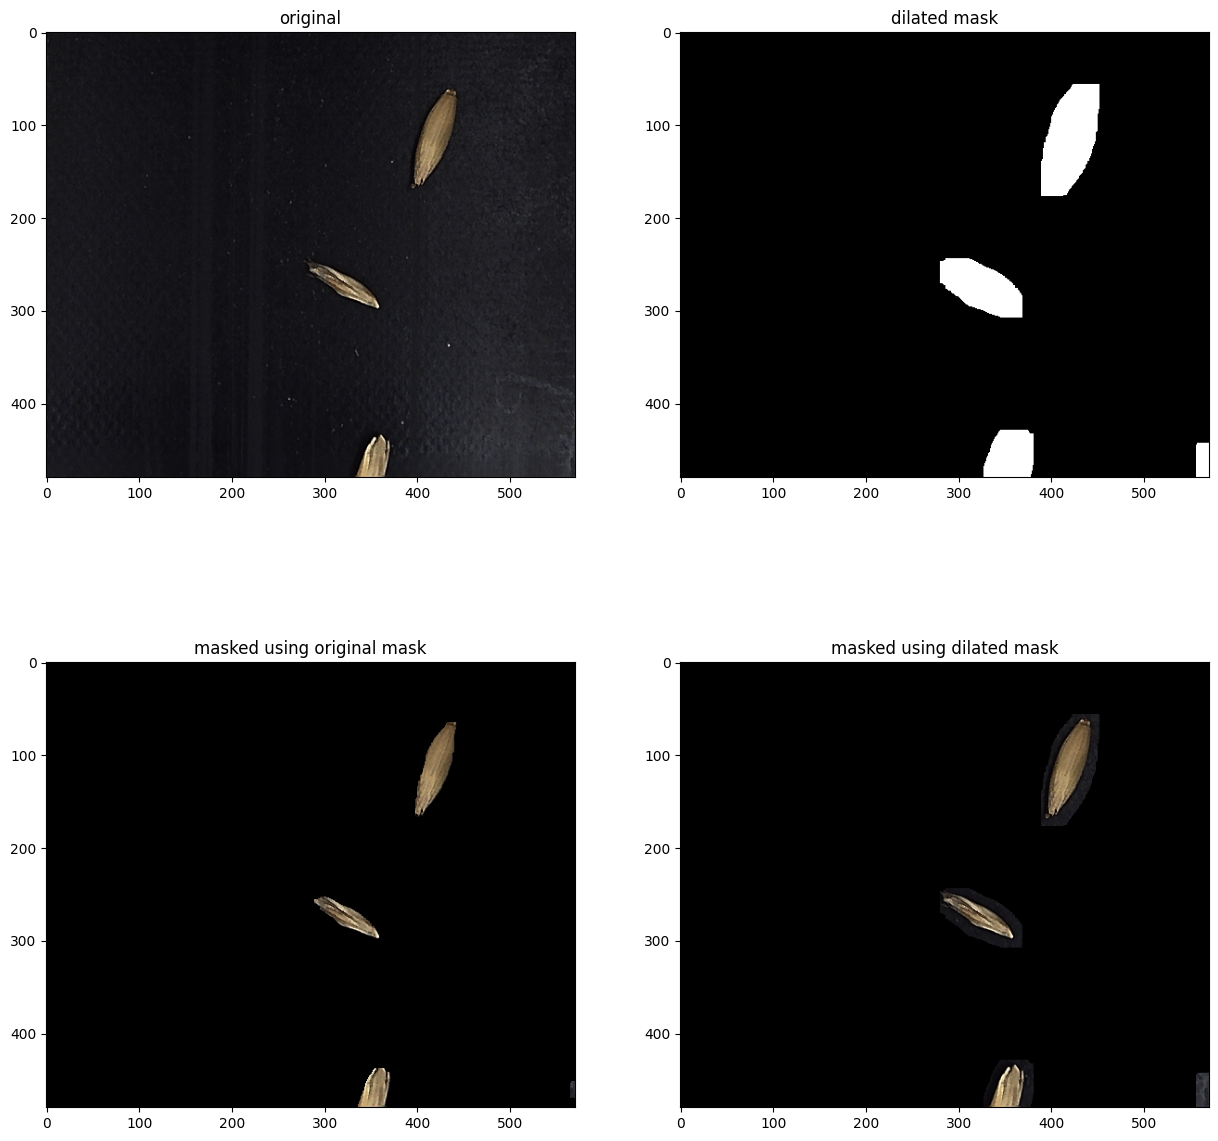

In [7]:
dilation_kernel = np.ones((20,20))

dilated = cv2.dilate(test_closed_opened, dilation_kernel)


fig, ax = plt.subplots(2,2, figsize=(15,15))
ax[0,0].imshow(cropped_frames[80])
ax[0,0].set_title('original')
ax[0,1].imshow(dilated, 'gray',vmin=0,vmax=255)
ax[0,1].set_title('dilated mask')
ax[1,0].imshow(cropped_frames[80] * np.repeat((test_closed_opened // 255)[...,None], 3, axis=2))
ax[1,0].set_title('masked using original mask')
ax[1,1].imshow(cropped_frames[80] * np.repeat((dilated // 255)[...,None], 3, axis=2))
ax[1,1].set_title('masked using dilated mask')

In [10]:
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 10;
params.maxThreshold = 200;
 
# Filter by Area.
params.filterByArea = True
params.minArea = 25
 
# Filter by Circularity
params.filterByCircularity = False
# params.minCircularity = 0.1
 
# Filter by Convexity
params.filterByConvexity = False
# params.minConvexity = 0.87
 
# Filter by Inertia
params.filterByInertia = False
# params.minInertiaRatio = 0.01

blob_detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs in the undilated mask
blobs = blob_detector.detect(test_closed_opened)
params.__dict__

AttributeError: 'cv2.SimpleBlobDetector.Params' object has no attribute '__dict__'